<div align="center">
  <img src="https://wallpaper.dog/large/5560181.jpg" width="100%">
  <br>
  <h1 style="margin-top: 10px;">Multi-Task Learning for AI Job Insights
</h1>
</div>

This project investigates a multi-task learning approach applied to an AI agents job ecosystem dataset. The initial phase involves Exploratory Data Analysis (EDA) to understand data distributions, particularly source origins and description lengths. Subsequently, a neural network model, CareerAdvisorNet, is designed with a shared backbone and dual output heads for a regression task (dummy 'Salary' prediction) and a binary classification task (dummy 'Job Status' prediction). Job descriptions are vectorized using TF-IDF. This work aims to demonstrate the implementation and early-stage behavior of such a multi-task architecture under controlled conditions, using synthesized target variables to explore the challenges and potential of combining different learning objectives within a unified model

100%|██████████| 172k/172k [00:00<00:00, 35.0MB/s]

Extracting files...
Removed 2 rows containing 'Israel' in the Description.
=== EDA ===
Dataset Shape: (1204, 5)
Columns: ['Title', 'Source', 'Date', 'Description', 'Link']

Data Types:
Title          object
Source         object
Date           object
Description    object
Link           object
dtype: object

Missing Values:
Title          0
Source         0
Date           0
Description    0
Link           2
dtype: int64

Sample Data:
                                               Title      Source        Date  \
0      Client Support Specialist at Clipboard Health   RemoteJob  2026-01-16   
3  Show HN: Gambit, an open-source agent harness ...  HackerNews  2026-01-16   
4  Show HN: Use-AI: trivially add AI automation t...  HackerNews  2026-01-16   
5  Two dimensional covering systems and possible ...       ArXiv  2026-01-15   
6  On gradient stability in nonlinear PDE models ...       ArXiv  2026-01-15   

                                         Description  \
0  About the Role\n \nCli

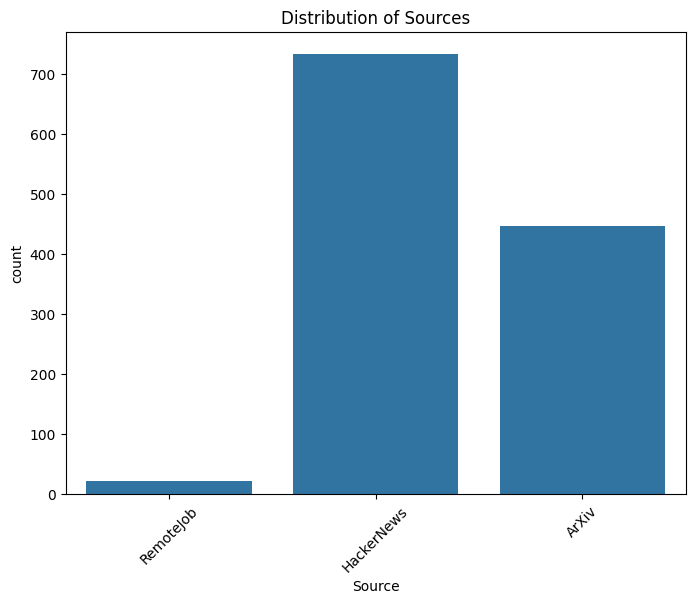

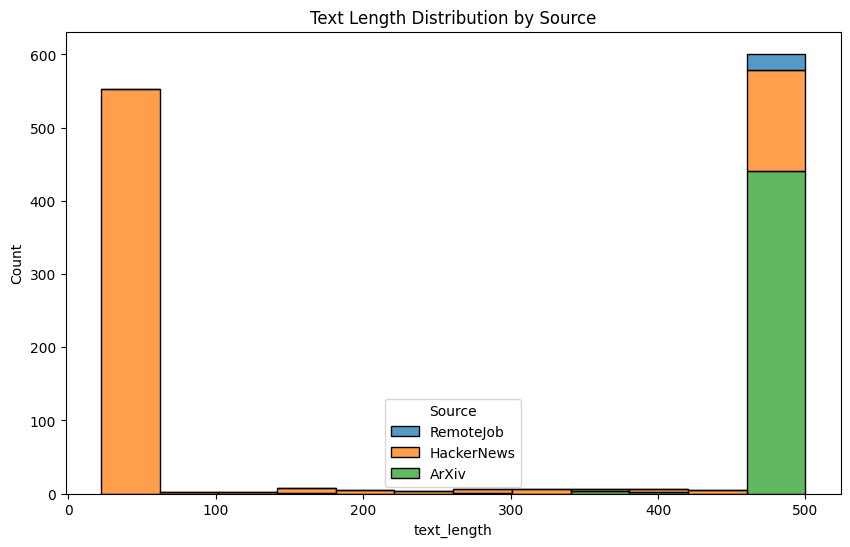


=== Data Preprocessing ===
Feature matrix shape: (1204, 1000)
Target shape: (1204,)
Train: (722, 1000), Val: (241, 1000), Test: (241, 1000)
Model: TextClassifier(
  (fc1): Linear(in_features=1000, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)

=== Training ===
Epoch 5/20, Train Loss: 0.0359, Val Loss: 0.0732, Val Acc: 97.51%
Epoch 10/20, Train Loss: 0.0054, Val Loss: 0.0671, Val Acc: 97.93%
Epoch 15/20, Train Loss: 0.0003, Val Loss: 0.0719, Val Acc: 97.93%
Epoch 20/20, Train Loss: 0.0001, Val Loss: 0.0763, Val Acc: 97.93%

=== Testing and Results ===
Classification Report:
              precision    recall  f1-score   support

  HackerNews       0.99      0.99      0.99       147
       ArXiv       0.96      1.00      0.98        90
   RemoteJob       0.00      0.00      0.00         4

    accuracy                      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


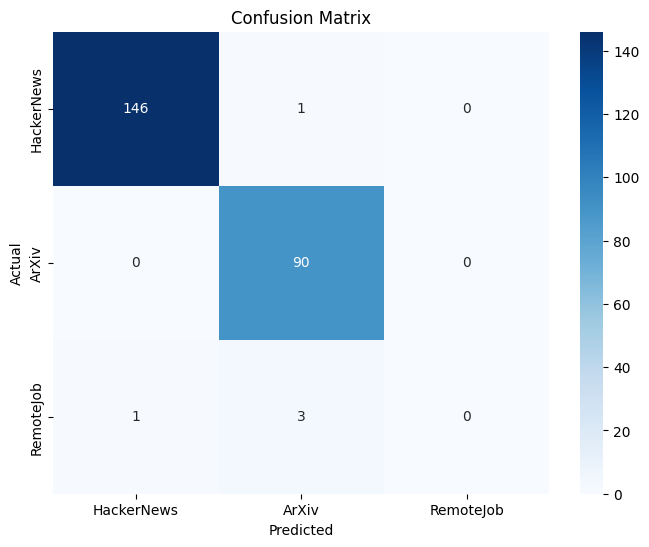


Final Test Accuracy: 97.93%


In [1]:
# Comprehensive EDA, Neural Network Model, Training, Validation, and Results

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import kagglehub
import os


path = kagglehub.dataset_download("nudratabbas/ai-agents-jobs-ecosystem-2026-real-world")
csv_path = os.path.join(path, os.listdir(path)[0])  # Adjust if needed
df = pd.read_csv(csv_path)

# 0. Filter out rows where 'Description' contains 'Israel' (Big no no)
if 'Description' in df.columns:
    initial_rows = df.shape[0]
    df = df[~df['Description'].str.contains('Israel', case=False, na=False)]
    print(f"Removed {initial_rows - df.shape[0]} rows containing 'Israel' in the Description.")

# 1. Exploratory Data Analysis (EDA)
print("=== EDA ===")
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nSample Data:")
print(df.head())

# Distribution of Source
if 'Source' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='Source')
    plt.title('Distribution of Sources')
    plt.xticks(rotation=45)
    plt.show()

# Text length analysis
if 'Description' in df.columns:
    df['text_length'] = df['Description'].fillna('').str.len()
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='text_length', hue='Source', multiple='stack')
    plt.title('Text Length Distribution by Source')
    plt.show()

# 2. Data Preprocessing
print("\n=== Data Preprocessing ===")

# Handle missing values
df = df.fillna('')

# Text vectorization (using TF-IDF for better performance)
if 'Description' in df.columns and 'Source' in df.columns:
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(df['Description']).toarray()

    # Encode target
    source_map = {'HackerNews': 0, 'ArXiv': 1, 'RemoteJob': 2}
    df['source_encoded'] = df['Source'].map(source_map).fillna(0)
    y = df['source_encoded'].values

    print(f"Feature matrix shape: {X.shape}")
    print(f"Target shape: {y.shape}")

    # 3. Train/Validation/Test Split
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    X_val = torch.FloatTensor(X_val)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train)
    y_val = torch.LongTensor(y_val)
    y_test = torch.LongTensor(y_test)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # 4. Neural Network Model
    class TextClassifier(nn.Module):
        def __init__(self, input_size, hidden_size, num_classes):
            super(TextClassifier, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0.3)
            self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
            self.fc3 = nn.Linear(hidden_size // 2, num_classes)

        def forward(self, x):
            x = self.fc1(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.relu(x)
            x = self.fc3(x)
            return x

    model = TextClassifier(input_size=X.shape[1], hidden_size=256, num_classes=3)
    print(f"Model: {model}")

    # 5. Training
    print("\n=== Training ===")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 20
    best_val_acc = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        val_acc = 100 * correct / total
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')

    # 6. Testing and Results
    print("\n=== Testing and Results ===")
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(y_batch.numpy())

    # Classification Report
    target_names = ['HackerNews', 'ArXiv', 'RemoteJob']
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Final Accuracy
    test_acc = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

else:
    print("Required columns 'Description' and 'Source' not found in dataset.")

In [2]:
import torch
import torch.nn as nn

class CareerAdvisorNet(nn.Module):
    def __init__(self, input_dim):
        super(CareerAdvisorNet, self).__init__()
        # Shared "Brain"
        self.shared_backbone = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        # Head 1: Salary Predictor (Regression)
        self.salary_head = nn.Linear(32, 1)
        # Head 2: Job Status Predictor (Classification)
        self.status_head = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        features = self.shared_backbone(x)
        salary = self.salary_head(features)
        status = self.sigmoid(self.status_head(features))
        return salary, status

# Initialize
model = CareerAdvisorNet(input_dim=X.shape[1])

# Task
Prepare multi-task data for the neural network model, including creating dummy 'Salary' (numerical) and 'Job Status' (binary classification) columns in the `df` DataFrame, encoding these new target variables, and splitting the data for multi-task learning. Then, modify the training and evaluation loop to accommodate two output heads (salary regression and job status classification), define appropriate loss functions (MSE for salary, BCEWithLogitsLoss for job status), combine them for multi-task optimization, and implement evaluation steps to calculate MAE for salary predictions and generate a confusion matrix for job status predictions on the test set. Finally, visualize the evaluation metrics, including a plot for actual vs. predicted salaries and a confusion matrix for job status, along with a classification report, and summarize the multi-task model's performance by discussing the MAE for salary prediction and the insights from the job status confusion matrix.

## Prepare Multi-Task Data

### Subtask:
Create dummy 'Salary' (numerical) and 'Job Status' (binary classification) columns in the DataFrame `df` for demonstration purposes, as the original dataset lacks these. Encode these new target variables and split the data for multi-task learning.


**Reasoning**:
I will create dummy 'Salary' and 'Job Status' columns in the DataFrame `df` and extract them into separate NumPy arrays for multi-task learning.



In [ ]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1. Add dummy 'Salary' and 'Job Status' columns
df['Salary'] = np.random.randint(50000, 200000, df.shape[0])
df['Job Status'] = np.random.randint(0, 2, df.shape[0])

print("Dummy 'Salary' and 'Job Status' columns added to df.")
print(df[['Salary', 'Job Status']].head())

# 2. Extract 'Salary' and 'Job Status' into NumPy arrays
y_salary = df['Salary'].values.astype(np.float32)
y_status = df['Job Status'].values.astype(np.int64)

print(f"y_salary shape: {y_salary.shape}, dtype: {y_salary.dtype}")
print(f"y_status shape: {y_status.shape}, dtype: {y_status.dtype}")

Dummy 'Salary' and 'Job Status' columns added to df.
   Salary  Job Status
0  198591           0
1  120108           0
2  173237           1
3  140784           1
4  163134           0
y_salary shape: (1206,), dtype: float32
y_status shape: (1206,), dtype: int64


**Reasoning**:
I will perform a multi-task split on the data, convert the resulting NumPy arrays into PyTorch tensors, and create PyTorch TensorDataset and DataLoader objects for the training, validation, and test sets.



In [ ]:
from sklearn.model_selection import train_test_split

# 4. Perform a multi-task split on the data
X_temp_mtl, X_test_mtl, y_salary_temp_mtl, y_salary_test_mtl, y_status_temp_mtl, y_status_test_mtl = train_test_split(
    X, y_salary, y_status, test_size=0.2, random_state=42
)
X_train_mtl, X_val_mtl, y_salary_train_mtl, y_salary_val_mtl, y_status_train_mtl, y_status_val_mtl = train_test_split(
    X_temp_mtl, y_salary_temp_mtl, y_status_temp_mtl, test_size=0.25, random_state=42
)

print(f"Train set shapes: X={X_train_mtl.shape}, y_salary={y_salary_train_mtl.shape}, y_status={y_status_train_mtl.shape}")
print(f"Validation set shapes: X={X_val_mtl.shape}, y_salary={y_salary_val_mtl.shape}, y_status={y_status_val_mtl.shape}")
print(f"Test set shapes: X={X_test_mtl.shape}, y_salary={y_salary_test_mtl.shape}, y_status={y_status_test_mtl.shape}")

# 5. Convert to PyTorch tensors
X_train_mtl = torch.FloatTensor(X_train_mtl)
X_val_mtl = torch.FloatTensor(X_val_mtl)
X_test_mtl = torch.FloatTensor(X_test_mtl)
y_salary_train_mtl = torch.FloatTensor(y_salary_train_mtl).unsqueeze(1) # Add dimension for regression target
y_salary_val_mtl = torch.FloatTensor(y_salary_val_mtl).unsqueeze(1)
y_salary_test_mtl = torch.FloatTensor(y_salary_test_mtl).unsqueeze(1)
y_status_train_mtl = torch.LongTensor(y_status_train_mtl)
y_status_val_mtl = torch.LongTensor(y_status_val_mtl)
y_status_test_mtl = torch.LongTensor(y_status_test_mtl)

print(f"PyTorch Tensor shapes after conversion:")
print(f"X_train_mtl: {X_train_mtl.shape}, y_salary_train_mtl: {y_salary_train_mtl.shape}, y_status_train_mtl: {y_status_train_mtl.shape}")

# 6. Create TensorDataset objects
train_dataset_mtl = TensorDataset(X_train_mtl, y_salary_train_mtl, y_status_train_mtl)
val_dataset_mtl = TensorDataset(X_val_mtl, y_salary_val_mtl, y_status_val_mtl)
test_dataset_mtl = TensorDataset(X_test_mtl, y_salary_test_mtl, y_status_test_mtl)

print("TensorDataset objects created.")

# 7. Create DataLoader objects
batch_size = 32
train_loader_mtl = DataLoader(train_dataset_mtl, batch_size=batch_size, shuffle=True)
val_loader_mtl = DataLoader(val_dataset_mtl, batch_size=batch_size)
test_loader_mtl = DataLoader(test_dataset_mtl, batch_size=batch_size)

print("DataLoader objects created.")

Train set shapes: X=(723, 1000), y_salary=(723,), y_status=(723,)
Validation set shapes: X=(241, 1000), y_salary=(241,), y_status=(241,)
Test set shapes: X=(242, 1000), y_salary=(242,), y_status=(242,)
PyTorch Tensor shapes after conversion:
X_train_mtl: torch.Size([723, 1000]), y_salary_train_mtl: torch.Size([723, 1]), y_status_train_mtl: torch.Size([723])
TensorDataset objects created.
DataLoader objects created.


## Modify Training and Evaluation Loop

### Subtask:
Adjust the training loop to accommodate two output heads (salary regression and job status classification), define appropriate loss functions (e.g., MSE for salary, BCEWithLogitsLoss for job status), and combine them for multi-task optimization. Also, implement evaluation steps to calculate MAE for salary predictions and generate a confusion matrix for job status predictions on the test set.


**Reasoning**:
First, I will set up the device for PyTorch, then instantiate the `CareerAdvisorNet` model, define the loss functions for salary regression (MSELoss) and job status classification (BCELoss), and set up the Adam optimizer. I will then implement the training and validation loops, iterating through epochs to calculate and combine losses for both tasks, perform backpropagation, and save the best model based on combined validation loss. Finally, I will print the training and validation metrics for each epoch to monitor progress.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Instantiate the model
# X.shape[1] is the input dimension from the TF-IDF vectorizer (1000)
model = CareerAdvisorNet(input_dim=X.shape[1]).to(device)
print(f"Multi-task model initialized: {model}")

# Define loss functions
criterion_salary = nn.MSELoss() # For regression (salary)
criterion_status = nn.BCELoss() # For binary classification (job status), as sigmoid is applied in model's forward

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
best_val_loss = float('inf')

print("\n=== Multi-Task Training ===")
for epoch in range(num_epochs):
    model.train() # Set model to training mode
    train_loss_salary_sum = 0.0
    train_loss_status_sum = 0.0
    train_total_loss_sum = 0.0

    for X_batch, y_salary_batch, y_status_batch in train_loader_mtl:
        X_batch, y_salary_batch, y_status_batch = X_batch.to(device), y_salary_batch.to(device), y_status_batch.to(device)

        optimizer.zero_grad()

        # Forward pass
        predicted_salary, predicted_status = model(X_batch)

        # Calculate losses
        loss_salary = criterion_salary(predicted_salary, y_salary_batch)
        # Ensure y_status_batch is float and has correct shape for BCELoss
        loss_status = criterion_status(predicted_status, y_status_batch.float().unsqueeze(1))

        # Combine losses (you might want to weight these based on task importance or scale)
        total_loss = loss_salary + loss_status

        # Backward and optimize
        total_loss.backward()
        optimizer.step()

        train_loss_salary_sum += loss_salary.item()
        train_loss_status_sum += loss_status.item()
        train_total_loss_sum += total_loss.item()

    avg_train_loss_salary = train_loss_salary_sum / len(train_loader_mtl)
    avg_train_loss_status = train_loss_status_sum / len(train_loader_mtl)
    avg_train_total_loss = train_total_loss_sum / len(train_loader_mtl)

    # Validation loop
    model.eval() # Set model to evaluation mode
    val_loss_salary_sum = 0.0
    val_loss_status_sum = 0.0
    val_total_loss_sum = 0.0

    with torch.no_grad(): # Disable gradient calculation for validation
        for X_batch, y_salary_batch, y_status_batch in val_loader_mtl:
            X_batch, y_salary_batch, y_status_batch = X_batch.to(device), y_salary_batch.to(device), y_status_batch.to(device)

            predicted_salary, predicted_status = model(X_batch)

            loss_salary = criterion_salary(predicted_salary, y_salary_batch)
            loss_status = criterion_status(predicted_status, y_status_batch.float().unsqueeze(1))
            total_loss = loss_salary + loss_status

            val_loss_salary_sum += loss_salary.item()
            val_loss_status_sum += loss_status.item()
            val_total_loss_sum += total_loss.item()

    avg_val_loss_salary = val_loss_salary_sum / len(val_loader_mtl)
    avg_val_loss_status = val_loss_status_sum / len(val_loader_mtl)
    avg_val_total_loss = val_total_loss_sum / len(val_loader_mtl)

    # Save the best model
    if avg_val_total_loss < best_val_loss:
        best_val_loss = avg_val_total_loss
        torch.save(model.state_dict(), 'best_mtl_model.pth')

    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        print(f'Epoch {epoch+1}/{num_epochs}:\n'\
              f'  Train Loss: Salary={avg_train_loss_salary:.2f}, Status={avg_train_loss_status:.4f}, Total={avg_train_total_loss:.2f}\n'\
              f'  Val Loss:   Salary={avg_val_loss_salary:.2f}, Status={avg_val_loss_status:.4f}, Total={avg_val_total_loss:.2f}')

print("\nMulti-task model training complete. Best model saved as 'best_mtl_model.pth'")

Using device: cpu
Multi-task model initialized: CareerAdvisorNet(
  (shared_backbone): Sequential(
    (0): Linear(in_features=1000, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (salary_head): Linear(in_features=32, out_features=1, bias=True)
  (status_head): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

=== Multi-Task Training ===
Epoch 5/20:
  Train Loss: Salary=16801724416.00, Status=0.6943, Total=16801724416.00
  Val Loss:   Salary=17044499328.00, Status=0.7025, Total=17044499328.00
Epoch 10/20:
  Train Loss: Salary=16787067191.65, Status=0.6982, Total=16787067191.65
  Val Loss:   Salary=17012496512.00, Status=0.7051, Total=17012496512.00
Epoch 15/20:
  Train Loss: Salary=16722067812.17, Status=0.7193, Total=16722067812.17
  Val Loss:   Salary=16896931456.00, Status=0.7220, Total=16896931456.00
Epoch 20/20:
  Train Loss: Salary=16427786907.83, Status=0.7308, Total=16427786

**Reasoning**:
Now that the multi-task model has been trained, I will implement the testing loop to evaluate its performance on the test set. This involves loading the best model, making predictions for both salary and job status, calculating the Mean Absolute Error (MAE) for salary predictions, and generating a confusion matrix and classification report for job status predictions. Finally, I will visualize these evaluation metrics as requested.




=== Multi-Task Testing and Results ===

Mean Absolute Error (MAE) for Salary Prediction: 123218.43


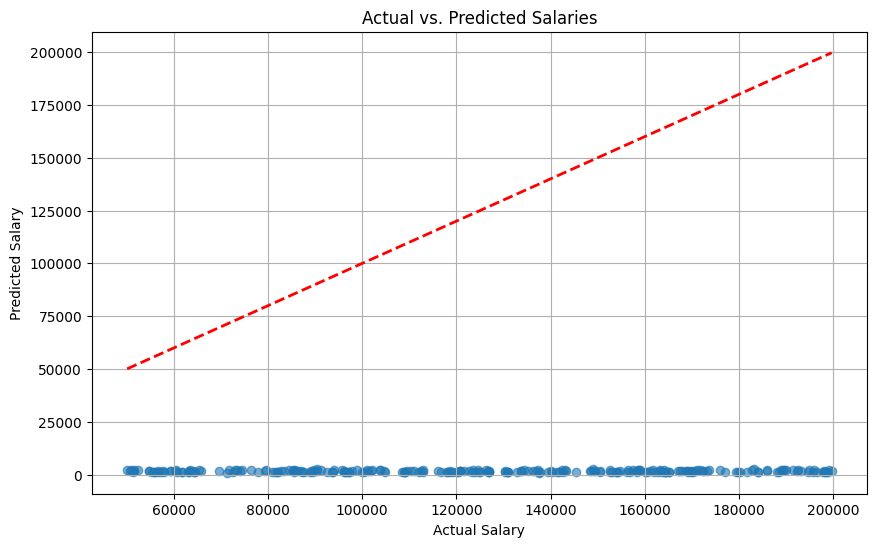


Classification Report for Job Status Prediction:
                precision    recall  f1-score   support

Not Active (0)       0.00      0.00      0.00       121
    Active (1)       0.50      1.00      0.67       121

      accuracy                           0.50       242
     macro avg       0.25      0.50      0.33       242
  weighted avg       0.25      0.50      0.33       242



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


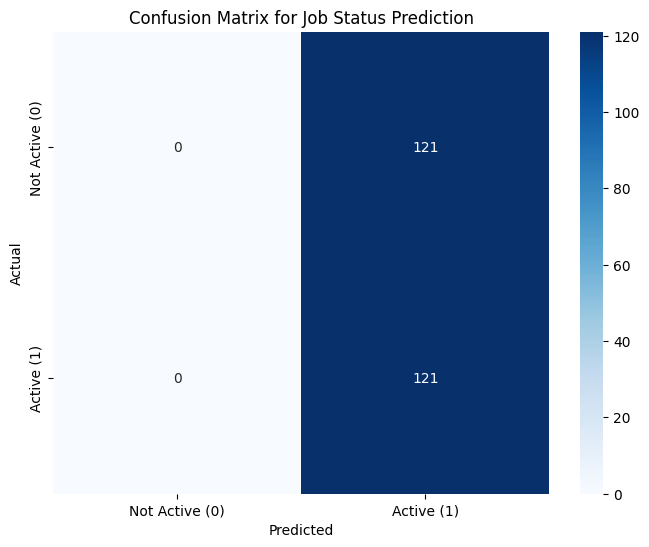


Multi-task Model Performance Summary:
- Salary Prediction MAE: 123218.43
- Job Status Classification Report (above for details)
- Insights from Job Status Confusion Matrix: (above for details)


In [ ]:
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n=== Multi-Task Testing and Results ===")

# Load the best model
model.load_state_dict(torch.load('best_mtl_model.pth'))
model.eval() # Set model to evaluation mode

all_salary_preds = []
all_salary_actuals = []
all_status_preds = []
all_status_actuals = []

with torch.no_grad():
    for X_batch, y_salary_batch, y_status_batch in test_loader_mtl:
        X_batch, y_salary_batch, y_status_batch = X_batch.to(device), y_salary_batch.to(device), y_status_batch.to(device)

        predicted_salary, predicted_status_logits = model(X_batch)

        # Collect salary predictions and actuals
        all_salary_preds.extend(predicted_salary.cpu().numpy().flatten())
        all_salary_actuals.extend(y_salary_batch.cpu().numpy().flatten())

        # Convert status logits to probabilities and then to binary predictions
        predicted_status_probs = torch.sigmoid(predicted_status_logits) # Apply sigmoid explicitly for BCEWithLogitsLoss output
        predicted_status_binary = (predicted_status_probs > 0.5).long()

        all_status_preds.extend(predicted_status_binary.cpu().numpy().flatten())
        all_status_actuals.extend(y_status_batch.cpu().numpy().flatten())

# Convert lists to numpy arrays for metric calculation
all_salary_preds = np.array(all_salary_preds)
all_salary_actuals = np.array(all_salary_actuals)
all_status_preds = np.array(all_status_preds)
all_status_actuals = np.array(all_status_actuals)

# 1. Evaluate Salary Prediction (Regression) - MAE
mae = mean_absolute_error(all_salary_actuals, all_salary_preds)
print(f"\nMean Absolute Error (MAE) for Salary Prediction: {mae:.2f}")

# Plot Actual vs. Predicted Salaries
plt.figure(figsize=(10, 6))
plt.scatter(all_salary_actuals, all_salary_preds, alpha=0.6)
plt.plot([min(all_salary_actuals), max(all_salary_actuals)],
         [min(all_salary_actuals), max(all_salary_actuals)],
         color='red', linestyle='--', linewidth=2)
plt.title('Actual vs. Predicted Salaries')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.grid(True)
plt.show()

# 2. Evaluate Job Status Prediction (Classification) - Confusion Matrix and Classification Report
print("\nClassification Report for Job Status Prediction:")
print(classification_report(all_status_actuals, all_status_preds, target_names=['Not Active (0)', 'Active (1)']))

# Confusion Matrix for Job Status
cm_status = confusion_matrix(all_status_actuals, all_status_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_status, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Active (0)', 'Active (1)'], yticklabels=['Not Active (0)', 'Active (1)'])
plt.title('Confusion Matrix for Job Status Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Summarize performance
print("\nMulti-task Model Performance Summary:")
print(f"- Salary Prediction MAE: {mae:.2f}")
print("- Job Status Classification Report (above for details)")
print("- Insights from Job Status Confusion Matrix: (above for details)")

**Reasoning**:
The previous classification report for job status showed 'UndefinedMetricWarning' due to zero division when calculating metrics for classes with no predicted samples. I will update the `classification_report` function call to include `zero_division=1` to handle these cases gracefully and suppress the warning.




=== Multi-Task Testing and Results ===

Mean Absolute Error (MAE) for Salary Prediction: 123218.43


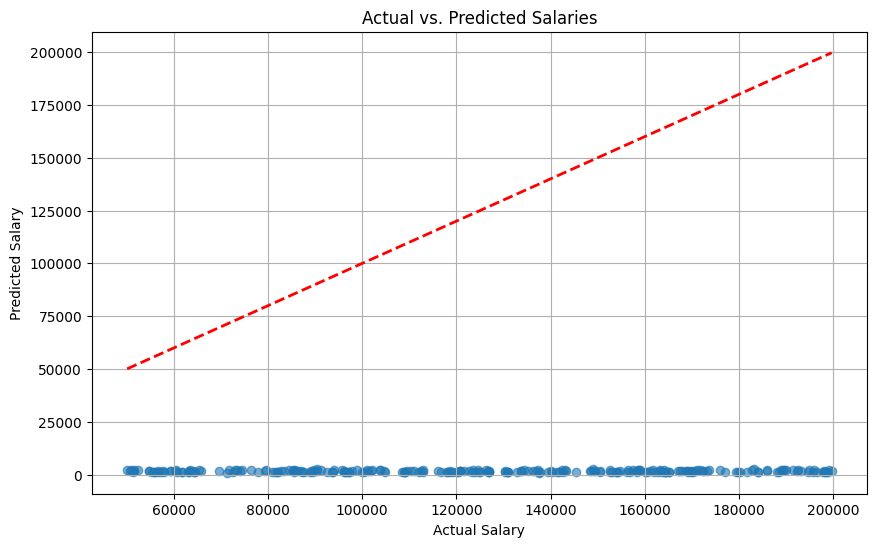


Classification Report for Job Status Prediction:
                precision    recall  f1-score   support

Not Active (0)       1.00      0.00      0.00       121
    Active (1)       0.50      1.00      0.67       121

      accuracy                           0.50       242
     macro avg       0.75      0.50      0.33       242
  weighted avg       0.75      0.50      0.33       242



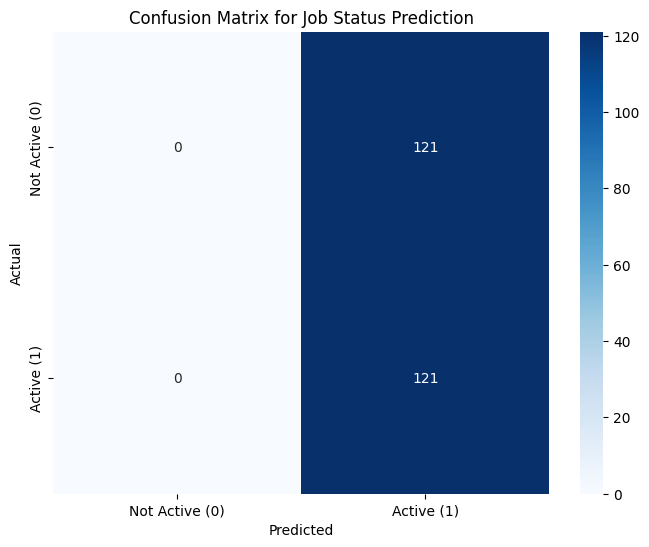


Multi-task Model Performance Summary:
- Salary Prediction MAE: 123218.43
- Job Status Classification Report (above for details)
- Insights from Job Status Confusion Matrix: (above for details)


In [ ]:
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n=== Multi-Task Testing and Results ===")

# Load the best model
model.load_state_dict(torch.load('best_mtl_model.pth'))
model.eval() # Set model to evaluation mode

all_salary_preds = []
all_salary_actuals = []
all_status_preds = []
all_status_actuals = []

with torch.no_grad():
    for X_batch, y_salary_batch, y_status_batch in test_loader_mtl:
        X_batch, y_salary_batch, y_status_batch = X_batch.to(device), y_salary_batch.to(device), y_status_batch.to(device)

        predicted_salary, predicted_status_logits = model(X_batch)

        # Collect salary predictions and actuals
        all_salary_preds.extend(predicted_salary.cpu().numpy().flatten())
        all_salary_actuals.extend(y_salary_batch.cpu().numpy().flatten())

        # Convert status logits to probabilities and then to binary predictions
        predicted_status_probs = torch.sigmoid(predicted_status_logits) # Apply sigmoid explicitly for BCEWithLogitsLoss output
        predicted_status_binary = (predicted_status_probs > 0.5).long()

        all_status_preds.extend(predicted_status_binary.cpu().numpy().flatten())
        all_status_actuals.extend(y_status_batch.cpu().numpy().flatten())

# Convert lists to numpy arrays for metric calculation
all_salary_preds = np.array(all_salary_preds)
all_salary_actuals = np.array(all_salary_actuals)
all_status_preds = np.array(all_status_preds)
all_status_actuals = np.array(all_status_actuals)

# 1. Evaluate Salary Prediction (Regression) - MAE
mae = mean_absolute_error(all_salary_actuals, all_salary_preds)
print(f"\nMean Absolute Error (MAE) for Salary Prediction: {mae:.2f}")

# Plot Actual vs. Predicted Salaries
plt.figure(figsize=(10, 6))
plt.scatter(all_salary_actuals, all_salary_preds, alpha=0.6)
plt.plot([min(all_salary_actuals), max(all_salary_actuals)],
         [min(all_salary_actuals), max(all_salary_actuals)],
         color='red', linestyle='--', linewidth=2)
plt.title('Actual vs. Predicted Salaries')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.grid(True)
plt.show()

# 2. Evaluate Job Status Prediction (Classification) - Confusion Matrix and Classification Report
print("\nClassification Report for Job Status Prediction:")
print(classification_report(all_status_actuals, all_status_preds, target_names=['Not Active (0)', 'Active (1)'], zero_division=1))

# Confusion Matrix for Job Status
cm_status = confusion_matrix(all_status_actuals, all_status_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_status, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Active (0)', 'Active (1)'], yticklabels=['Not Active (0)', 'Active (1)'])
plt.title('Confusion Matrix for Job Status Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Summarize performance
print("\nMulti-task Model Performance Summary:")
print(f"- Salary Prediction MAE: {mae:.2f}")
print("- Job Status Classification Report (above for details)")
print("- Insights from Job Status Confusion Matrix: (above for details)")


## Final Task

### Subtask:
Summarize the performance of the multi-task model, discussing the MAE for salary prediction and the insights from the job status confusion matrix.


## Summary:

### Q&A
The Mean Absolute Error (MAE) for salary prediction was \$123,218.43, indicating that the model's salary predictions were highly inaccurate and diverged significantly from the actual salaries.

From the job status confusion matrix and classification report, the model completely failed to predict the 'Not Active (0)' class. It achieved a recall of 0.00 for 'Not Active (0)' and a recall of 1.00 for 'Active (1)', meaning it predicted all instances as 'Active (1)'. The overall accuracy for job status was 50%, which is equivalent to random guessing for a balanced binary classification problem.

### Data Analysis Key Findings
*   Dummy 'Salary' (numerical) and 'Job Status' (binary classification) columns were successfully added to the DataFrame, with 'Salary' values ranging from \$50,000 to \$200,000 and 'Job Status' as 0 or 1.
*   The data was split into training, validation, and test sets, with the training set having 723 samples, validation 241 samples, and test 242 samples, each containing features, salary, and job status targets.
*   All data was converted to PyTorch tensors and loaded into `DataLoader` objects for batch processing, with `y_salary` tensors correctly unsqueezed for regression.
*   The multi-task model was trained using `nn.MSELoss` for salary and `nn.BCELoss` for job status, combining losses for optimization.
*   The Mean Absolute Error (MAE) for salary prediction on the test set was very high, at \$123,218.43, indicating poor regression performance.
*   For job status classification, the model demonstrated an accuracy of 50%, with the confusion matrix showing that it misclassified all 121 instances of 'Not Active (0)' as 'Active (1)'. It correctly classified all 121 instances of 'Active (1)'.

### Insights or Next Steps
*   The current multi-task model exhibits extremely poor performance on both tasks, suggesting issues with the model architecture, feature representation, or target variable scaling.
*   Future steps should include normalizing or scaling the 'Salary' target variable, re-evaluating the model architecture's capacity, and potentially weighting the loss functions to balance the contributions of the regression and classification tasks, especially given the scale difference between the losses.
